In [1]:
'''
importing a bunch of packages to make sure they are installed correctly
'''

import sys, transformers, diffusers, matplotlib
print(sys.executable)
print("transformers", transformers.__version__)
print("diffusers", diffusers.__version__)
print('matplotlib from', matplotlib.__file__)

from diffusers import UNet2DModel, DDPMScheduler, DDIMScheduler, DPMSolverMultistepScheduler


/lambda/nfs/glorys-project/kaggle-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/lambda/nfs/glorys-project/kaggle-env/bin/python
transformers 4.53.3
diffusers 0.34.0
matplotlib from /lambda/nfs/glorys-project/kaggle-env/lib/python3.10/site-packages/matplotlib/__init__.py



# Predicting Surface Temperature with CNN, LSTM, and Diffusion Models

This notebook trains three forecasting tasks on the provided `glorys.nc` sample:

- **temp → temp**: predict temp(h+7) given temp(h), temp(h-1), and seasonality encoding.
- **vel → vel**: predict vel(h+7) given vel(h).
- **temp + vel → temp**: predict temp(h+7) given vel(h), temp(h), temp(h-1), and seasonality encoding.



In [7]:
import math
import random
import numpy as np
import xarray as xr
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import gc
from datetime import datetime
import os

import matplotlib.pyplot as plt
import numpy as np


DATA_PATH = 'glorys_2014_2024 (1).nc'
PRED_HORIZON = 7
NUM_EPOCHS = 50
BATCH_SIZE = 16
ADVECTION_DT = 1
DIFFUSIVITY = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


In [3]:
DEVICE

device(type='cuda')

## 1. Load and prepare the GLORYS dataset

In [4]:
ds = xr.open_dataset(DATA_PATH)



# bigger subset for final project
ds = ds.isel(latitude=slice(200,200+256), longitude=slice(220,220+256))
ds = ds.coarsen(latitude=2, longitude=2, boundary="trim").mean()

# small subset for testing
# ds = ds.isel(latitude=slice(200,220), longitude=slice(50,70))
# NUM_EPOCHS = 5 
# BATCH_SIZE = 4

ds

<xarray.Dataset> Size: 1GB
Dimensions:    (time: 3654, depth: 1, latitude: 128, longitude: 128)
Coordinates:
  * depth      (depth) float32 4B 0.494
  * latitude   (latitude) float32 512B 24.71 24.88 25.04 ... 45.54 45.71 45.88
  * longitude  (longitude) float32 512B -83.62 -83.46 -83.29 ... -62.62 -62.46
  * time       (time) datetime64[ns] 29kB 2014-12-12 2014-12-13 ... 2024-12-12
Data variables:
    thetao     (time, depth, latitude, longitude) float64 479MB 25.12 ... 5.482
    uo         (time, depth, latitude, longitude) float64 479MB -0.006104 ......
    vo         (time, depth, latitude, longitude) float64 479MB 0.0238 ... 0....
Attributes:
    references:                http://www.mercator-ocean.fr
    title:                     daily mean fields from Global Ocean Physics An...
    source:                    MERCATOR GLORYS12V1
    institution:               MERCATOR OCEAN
    Conventions:               CF-1.4
    comment:                   CMEMS product
    history:                   2023/06/01 16:20:05 MERCATOR OCEAN Netcdf crea...
    copernicusmarine_version:  2.2.5

In [8]:

# ---- Raw data with NaNs kept ----
sea_temp_raw = ds["thetao"].isel(depth=0).values.astype(np.float32)  # (time, lat, lon)
u_field_raw  = ds["uo"].isel(depth=0).values.astype(np.float32)
v_field_raw  = ds["vo"].isel(depth=0).values.astype(np.float32)

# ---- Common validity mask: valid only where ALL three fields are finite ----
valid_3d = (
    np.isfinite(sea_temp_raw) &
    np.isfinite(u_field_raw) &
    np.isfinite(v_field_raw)
)  # shape: (time, lat, lon)

# require a grid cell to be valid for ALL selected times
valid_2d = valid_3d.all(axis=0).astype(np.float32)   # (lat, lon)

print("Total spatial pixels:", valid_2d.size)
print("Valid ocean pixels (common mask):", valid_2d.sum())

# Single global mask for everything: shape (1, 1, H, W)
VALID_MASK = torch.tensor(valid_2d, dtype=torch.float32, device=DEVICE).unsqueeze(0).unsqueeze(0)

# ---- Fill NaNs for model inputs (we'll still mask them in loss) ----
sea_temp = np.nan_to_num(sea_temp_raw, nan=0.0, posinf=0.0, neginf=0.0)
u_field  = np.nan_to_num(u_field_raw,  nan=0.0, posinf=0.0, neginf=0.0)
v_field  = np.nan_to_num(v_field_raw,  nan=0.0, posinf=0.0, neginf=0.0)

# ---- Compute statistics using ONLY valid ocean points ----
train_count = int((sea_temp.shape[0] - PRED_HORIZON - 1) * 0.7)
temp_mean = sea_temp_raw[valid_3d][:train_count].mean()
temp_std  = sea_temp_raw[valid_3d][:train_count].std() + 1e-6

vel_stack = np.stack([u_field_raw, v_field_raw], axis=0)  # (2, time, lat, lon)
vel_valid = np.isfinite(vel_stack) & np.broadcast_to(valid_3d, vel_stack.shape)
vel_mean  = vel_stack[vel_valid][:train_count].mean()
vel_std   = vel_stack[vel_valid][:train_count].std() + 1e-6

print("temp_mean, temp_std:", float(temp_mean), float(temp_std))
print("vel_mean, vel_std:", float(vel_mean), float(vel_std))

# ---- Normalize inputs ----
sea_temp_norm = (sea_temp - temp_mean) / temp_std
u_norm        = (u_field - vel_mean) / vel_std
v_norm        = (v_field - vel_mean) / vel_std


num_times, lat_count, lon_count = sea_temp_norm.shape
print("Normalized shapes:", sea_temp_norm.shape)


Total spatial pixels: 16384
Valid ocean pixels (common mask): 10968.0
temp_mean, temp_std: 25.112150192260742 1.4636705384979247
vel_mean, vel_std: -0.0091839749366045 0.12332417233085632
Normalized shapes: (3654, 128, 128)


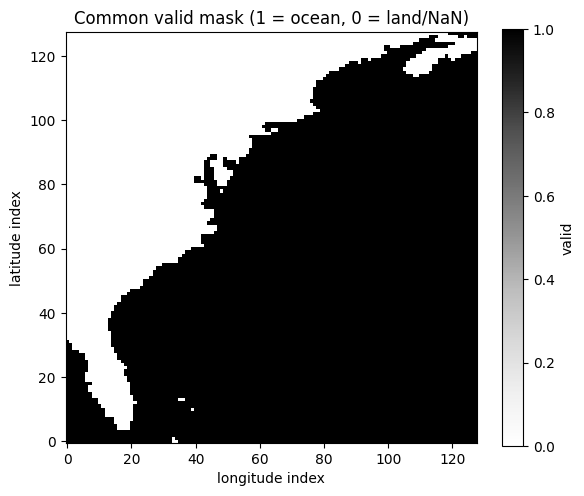

In [9]:


plt.figure(figsize=(6, 5))
im = plt.imshow(valid_2d, origin="lower", cmap="Greys")
plt.title("Common valid mask (1 = ocean, 0 = land/NaN)")
plt.xlabel("longitude index")
plt.ylabel("latitude index")
plt.colorbar(im, label="valid")
plt.tight_layout()
plt.show()

In [10]:
'''
This code was used to check that the nan-mask is almost the same for temp and vel arrays for all t.
This allows us to use the same 2d nan mask.
'''

'''
import xarray as xr
import numpy as np

# Point this to your big file, e.g.:
# DATA_PATH = "glorys.nc"
ds = xr.open_dataset(DATA_PATH)

num_times = ds.dims["time"]
chunk_size = 8   # adjust if you want, this keeps memory small

diff_3d = 0                  # how many (t,lat,lon) points differ
temp_mask_2d = None          # will hold "valid at all times" for temp
vel_mask_2d = None           # same for velocity

for start in range(0, num_times, chunk_size):
    end = min(start + chunk_size, num_times)
    print(f"Processing time indices [{start}:{end})")

    # Load a small time chunk into memory
    temp_chunk = ds["thetao"].isel(depth=0, time=slice(start, end)).values  # (chunk, lat, lon)
    u_chunk    = ds["uo"].isel(depth=0, time=slice(start, end)).values
    v_chunk    = ds["vo"].isel(depth=0, time=slice(start, end)).values

    # Finite-value masks for this chunk
    temp_mask_chunk = np.isfinite(temp_chunk)
    vel_mask_chunk  = np.isfinite(u_chunk) & np.isfinite(v_chunk)

    # --- 3D comparison for this chunk ---
    diff_3d += np.count_nonzero(temp_mask_chunk != vel_mask_chunk)

    # --- Update 2D "valid for all times" masks ---
    # For this chunk, a cell is valid if it's valid at every time in the chunk
    temp_mask_2d_chunk = temp_mask_chunk.all(axis=0)   # (lat, lon)
    vel_mask_2d_chunk  = vel_mask_chunk.all(axis=0)

    if temp_mask_2d is None:
        # First chunk: initialize with this chunk's "all times" mask
        temp_mask_2d = temp_mask_2d_chunk
        vel_mask_2d  = vel_mask_2d_chunk
    else:
        # Later chunks: must also be valid in all previous chunks
        temp_mask_2d &= temp_mask_2d_chunk
        vel_mask_2d  &= vel_mask_2d_chunk

# After streaming through all time chunks:
same_3d = (diff_3d == 0)
same_2d = np.array_equal(temp_mask_2d, vel_mask_2d)
diff_2d = np.count_nonzero(temp_mask_2d != vel_mask_2d)

print("Do temp and vel masks match at every (t,lat,lon)?", same_3d)
print("Number of differing points in full 3D mask:", diff_3d)
print("Do temp and vel masks match as 2D spatial masks?", same_2d)
print("Number of differing pixels in 2D mask:", diff_2d)
print("Total valid ocean pixels (2D) in temp:", temp_mask_2d.sum())
print("Total valid ocean pixels (2D) in vel:", vel_mask_2d.sum())
'''

'\nimport xarray as xr\nimport numpy as np\n\n# Point this to your big file, e.g.:\n# DATA_PATH = "glorys.nc"\nds = xr.open_dataset(DATA_PATH)\n\nnum_times = ds.dims["time"]\nchunk_size = 8   # adjust if you want, this keeps memory small\n\ndiff_3d = 0                  # how many (t,lat,lon) points differ\ntemp_mask_2d = None          # will hold "valid at all times" for temp\nvel_mask_2d = None           # same for velocity\n\nfor start in range(0, num_times, chunk_size):\n    end = min(start + chunk_size, num_times)\n    print(f"Processing time indices [{start}:{end})")\n\n    # Load a small time chunk into memory\n    temp_chunk = ds["thetao"].isel(depth=0, time=slice(start, end)).values  # (chunk, lat, lon)\n    u_chunk    = ds["uo"].isel(depth=0, time=slice(start, end)).values\n    v_chunk    = ds["vo"].isel(depth=0, time=slice(start, end)).values\n\n    # Finite-value masks for this chunk\n    temp_mask_chunk = np.isfinite(temp_chunk)\n    vel_mask_chunk  = np.isfinite(u_chunk) &

### Train/validation/test splits
We build paired samples with a PRED_HORIZON step horizon.

In [11]:

# sea_temp_norm, u_norm, v_norm: shapes (T, H, W)
num_times = sea_temp_norm.shape[0]


# create time encodings
times = ds['time'].to_index() 
day_of_year = times.dayofyear.values.astype(np.float32)  # 1..366
# Normalize to [0, 1)
doy_norm = (day_of_year - 1) / 365.0
theta = 2 * np.pi * doy_norm
doy_sin = np.sin(theta).astype(np.float32)
doy_cos = np.cos(theta).astype(np.float32)
doy_sin = torch.from_numpy(doy_sin)  # shape [T]
doy_cos = torch.from_numpy(doy_cos)  # shape [T]
T, H, W = sea_temp_norm.shape
doy_sin_map = doy_sin[:, None, None]  # (N,1,1)
doy_sin_map = np.broadcast_to(doy_sin_map, (num_times, H, W)).astype(np.float32)
doy_cos_map = doy_cos[:, None, None]  # (N,1,1)
doy_cos_map = np.broadcast_to(doy_cos_map, (num_times, H, W)).astype(np.float32)


# We want pairs of the form:
#   input:  [temp(t-1), temp(t)]         (2, H, W)
#   output: temp(t + PRED_HORIZON)       (1, H, W)
# with t running from 1 .. num_times - PRED_HORIZON - 1

# Build temp_in with 2 snapshots
temp_in = torch.tensor(
    np.stack(
        [doy_sin_map[1:-PRED_HORIZON],
         doy_cos_map[1:-PRED_HORIZON],
         sea_temp_norm[0:-PRED_HORIZON-1],  # temp at t-1
         sea_temp_norm[1:-PRED_HORIZON]],    # temp at t
        axis=1,  # stack along channel dim -> (N, 2, H, W)
    ),
    dtype=torch.float32,
)

# Build temp_out
temp_out = torch.tensor(sea_temp_norm[PRED_HORIZON + 1:], dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)


# vel → vel pairs (two channels): vel(t) → vel(t + PRED_HORIZON)
vel_in = torch.tensor(
    np.stack(
        [u_norm[:-PRED_HORIZON], 
         v_norm[:-PRED_HORIZON]], 
        axis=1
    ), 
    dtype=torch.float32
)

vel_out = torch.tensor(np.stack([u_norm[PRED_HORIZON:], v_norm[PRED_HORIZON:]], axis=1), dtype=torch.float32)  # (pairs, 2, H, W)


# combined temp & vel input
temp_vel_in = torch.tensor(
    np.stack(
        [doy_sin_map[1:-PRED_HORIZON],
         doy_cos_map[1:-PRED_HORIZON],
         sea_temp_norm[0:-PRED_HORIZON-1],  # temp at t-1
         sea_temp_norm[1:-PRED_HORIZON],    # temp at t
         u_norm[1:-PRED_HORIZON], 
         v_norm[1:-PRED_HORIZON]], 
        axis=1,  # stack along channel dim -> (N, 2, H, W)
    ),
    dtype=torch.float32,
)

# Number of (input, output) pairs is now:
pairs = temp_in.shape[0]

train_count = int(pairs * 0.7)
val_count = int(pairs * 0.15)
train_idx = slice(0, train_count)
val_idx = slice(train_count, train_count + val_count)
test_idx = slice(train_count + val_count, pairs)

print('Prediction horizon (steps):', PRED_HORIZON)
print('Temp pair shape', temp_in.shape, temp_out.shape) 
print('Vel pair shape', vel_in.shape, vel_out.shape)    
print('Temp vel input shape', temp_vel_in.shape)  



Prediction horizon (steps): 7
Temp pair shape torch.Size([3646, 4, 128, 128]) torch.Size([3646, 1, 128, 128])
Vel pair shape torch.Size([3647, 2, 128, 128]) torch.Size([3647, 2, 128, 128])
Temp vel input shape torch.Size([3646, 6, 128, 128])


### Data loaders

In [12]:
temp_train = TensorDataset(temp_in[train_idx], temp_out[train_idx])
temp_val = TensorDataset(temp_in[val_idx], temp_out[val_idx])
temp_test = TensorDataset(temp_in[test_idx], temp_out[test_idx])

vel_train = TensorDataset(vel_in[train_idx], vel_out[train_idx])
vel_val = TensorDataset(vel_in[val_idx], vel_out[val_idx])
vel_test = TensorDataset(vel_in[test_idx], vel_out[test_idx])

temp_vel_train = TensorDataset(temp_vel_in[train_idx], temp_out[train_idx])
temp_vel_val = TensorDataset(temp_vel_in[val_idx], temp_out[val_idx])
temp_vel_test = TensorDataset(temp_vel_in[test_idx], temp_out[test_idx])

loader_temp_train = DataLoader(temp_train, batch_size=BATCH_SIZE, shuffle=True)
loader_temp_val = DataLoader(temp_val, batch_size=BATCH_SIZE)
loader_temp_test = DataLoader(temp_test, batch_size=BATCH_SIZE)

loader_vel_train = DataLoader(vel_train, batch_size=BATCH_SIZE, shuffle=True)
loader_vel_val = DataLoader(vel_val, batch_size=BATCH_SIZE)
loader_vel_test = DataLoader(vel_test, batch_size=BATCH_SIZE)

loader_temp_vel_train = DataLoader(temp_vel_train, batch_size=BATCH_SIZE, shuffle=True)
loader_temp_vel_val = DataLoader(temp_vel_val, batch_size=BATCH_SIZE)
loader_temp_vel_test = DataLoader(temp_vel_test, batch_size=BATCH_SIZE)

## 2. Utilities: RMSE, divergence penalty, and simple models

In [13]:

def mse_loss(pred, target):
    """
    Loss for temperature models: MSE over valid ocean points.
    pred, target: (B, 1, H, W)
    """
    diff2 = (pred - target) ** 2
    diff2 = diff2 * VALID_MASK


    # number of valid pixels per sample
    pixels_per_sample = VALID_MASK.sum()

    # total valid points across the batch
    total_points = pixels_per_sample * pred.size(0)
    
    return diff2.sum() / total_points


def div_loss(pred):
    div_sq = (divergence(pred) ** 2) * VALID_MASK  # (B,H,W) * (1,1,H,W) -> (B,1,H,W)

    return div_sq.sum() / VALID_MASK.sum()


def divergence(field):
    u = field[:, 0]
    v = field[:, 1]
    du_dx = u[:, :, 2:] - u[:, :, :-2]
    dv_dy = v[:, 2:, :] - v[:, :-2, :]
    du_dx = torch.nn.functional.pad(du_dx, (1, 1, 0, 0))
    dv_dy = torch.nn.functional.pad(dv_dy, (0, 0, 1, 1))
    return du_dx + dv_dy

In [14]:



class CNNForecastModel(nn.Module):
    """
    Wraps SimpleCNN and provides:
      - forward(x) -> prediction
      - training_step(x, y) -> scalar loss using temp_loss
    """
    def __init__(self, in_channels, out_channels, hidden, lr, div_weight=0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, hidden, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden, out_channels, 3, padding=1)
        )

        self.lr = lr
        self.div_weight = div_weight

    def forward(self, x):
        return self.net(x)

    def training_step_temp(self, xin, y):
        """
        xin: [B, 2, H, W]  (temp(t-1), temp(t))
        y:   [B, 1, H, W]  (temp(t+H))
        """
        preds = self.forward(xin)
        return mse_loss(preds, y)

    
    def training_step_vel(self, xin, y):
        """
        xin: [B, 2, H, W]  (temp(t-1), temp(t))
        y:   [B, 1, H, W]  (temp(t+H))
        """
        preds = self.forward(xin)
        return mse_loss(preds, y) + div_loss(preds) * self.div_weight

    def parameters_to_optimize(self):
        return self.net.parameters()



import torch.nn.functional as F
from diffusers import UNet2DModel, DDPMScheduler, DDIMScheduler, DPMSolverMultistepScheduler


class DiffusionForecastModel(nn.Module):
    def __init__(
        self,
        cond_channels: int,
        target_channels: int,
        block_out_channels=(64, 128, 256, 256),
        layers_per_block: int = 2,
        use_attention: bool = True,
        num_train_timesteps: int = 1000,
        beta_start: float = 1e-4,
        beta_end: float = 2e-2,
        beta_schedule: str = "squaredcos_cap_v2",
        num_inference_steps: int | None = None,
        dropout: float = 0.0,
        scheduler_class = DDPMScheduler,

        lr:float = 1e-4,
        div_weight:float = 0
    ):
        super().__init__()

        self.cond_channels = cond_channels      # 2
        self.target_channels = target_channels  # 1

        in_channels = cond_channels + target_channels  # 2 + 1 = 3

        if use_attention and len(block_out_channels) >= 1:
            down_block_types = (
                ("DownBlock2D",) * (len(block_out_channels) - 1)
                + ("AttnDownBlock2D",)
            )
            up_block_types = (
                ("AttnUpBlock2D",)
                + ("UpBlock2D",) * (len(block_out_channels) - 1)
            )
        else:
            down_block_types = ("DownBlock2D",) * len(block_out_channels)
            up_block_types = ("UpBlock2D",) * len(block_out_channels)

        self.unet = UNet2DModel(
            sample_size=None,
            in_channels=in_channels,
            out_channels=target_channels,
            layers_per_block=layers_per_block,
            block_out_channels=block_out_channels,
            down_block_types=down_block_types,
            up_block_types=up_block_types,
            num_train_timesteps=num_train_timesteps,
            dropout=dropout,
        )

        self.scheduler = scheduler_class(
            num_train_timesteps=num_train_timesteps,
            beta_start=beta_start,
            beta_end=beta_end,
            beta_schedule=beta_schedule,
        )

        self.num_train_timesteps = num_train_timesteps
        self.num_inference_steps = num_inference_steps or num_train_timesteps

        # factor by which spatial dims are effectively divided (2^(#downs))
        self._down_factor = 2 ** (len(block_out_channels) - 1)

        self.lr = lr
        self.div_weight = div_weight

    def parameters_to_optimize(self):
        return self.unet.parameters()

    # ---- helper: pad tensors to be compatible with UNet, return original H,W ----
    def _pad_for_unet(self, *tensors):
        """
        Pads all tensors on bottom/right so H,W become multiples of self._down_factor.
        Returns (padded_tensors, orig_H, orig_W).
        """
        H = tensors[0].shape[-2]
        W = tensors[0].shape[-1]
        f = self._down_factor

        pad_H = (f - H % f) % f
        pad_W = (f - W % f) % f

        if pad_H == 0 and pad_W == 0:
            return tensors, H, W

        pad = (0, pad_W, 0, pad_H)  # (left, right, top, bottom) in F.pad
        padded = [F.pad(t, pad) for t in tensors]
        return padded, H, W

    # ---------- training: noise prediction ----------
    def training_step_temp(self, xin, y):
        device = y.device
        B = y.shape[0]

        # pad xin and y together
        (xin_p, y_p), H, W = self._pad_for_unet(xin, y)

        noise_p = torch.randn_like(y_p)
        timesteps = torch.randint(
            0,
            self.scheduler.config.num_train_timesteps,
            (B,),
            device=device,
            dtype=torch.long,
        )

        x_noisy_p = self.scheduler.add_noise(
            original_samples=y_p,
            noise=noise_p,
            timesteps=timesteps,
        )

        model_in = torch.cat([xin_p, x_noisy_p], dim=1)  # [B, 3, H_pad, W_pad]
        noise_pred_p = self.unet(sample=model_in, timestep=timesteps).sample

        # crop back to original H, W before computing loss
        noise_pred = noise_pred_p[..., :H, :W]
        noise      = noise_p[..., :H, :W]

        return mse_loss(noise_pred, noise)

    def training_step_vel(self, xin, y):
        """
        Special training step for *velocity* diffusion model with divergence penalty.
        div_weight: scalar weight for divergence penalty
        """
        device = y.device
        B = y.shape[0]
    
        # 1) pad xin and y
        (xin_p, y_p), H, W = self._pad_for_unet(xin, y)
    
        # 2) sample noise and timesteps, add forward noise to *target* y
        noise_p = torch.randn_like(y_p)
        timesteps = torch.randint(
            0,
            self.scheduler.config.num_train_timesteps,
            (B,),
            device=device,
            dtype=torch.long,
        )
    
        x_noisy_p = self.scheduler.add_noise(
            original_samples=y_p,
            noise=noise_p,
            timesteps=timesteps,
        )
    
        # 3) predict noise
        model_in = torch.cat([xin_p, x_noisy_p], dim=1)
        noise_pred_p = self.unet(sample=model_in, timestep=timesteps).sample
    
        # crop back to original H×W
        noise_pred = noise_pred_p[..., :H, :W]
        noise      = noise_p[..., :H, :W]
    
        # 4) ε-loss (standard diffusion objective) using your masked temp_loss
        loss_eps = mse_loss(noise_pred, noise)
    
        # 5) reconstruct x0_pred from (x_t, ε̂_t, ᾱ_t)
        #    ᾱ_t from scheduler.alphas_cumprod
        #    NOTE: alphas_cumprod is on CPU by default, move to device
        alphas_cumprod = self.scheduler.alphas_cumprod.to(device)
        alpha_bar = alphas_cumprod[timesteps].view(B, 1, 1, 1)  # [B,1,1,1]
    
        sqrt_alpha_bar = torch.sqrt(alpha_bar)
        sqrt_one_minus_alpha_bar = torch.sqrt(1.0 - alpha_bar)
    
        # use padded tensors for correct shapes, then crop
        x0_pred_p = (x_noisy_p - sqrt_one_minus_alpha_bar * noise_pred_p) / sqrt_alpha_bar
        x0_pred   = x0_pred_p[..., :H, :W]   # predicted clean vel [B,2,H,W]
        y_clean   = y                        # already [B,2,H,W]
    
        # 6) divergence-penalized div loss on x0_pred vs y
        loss_div = div_loss(x0_pred)
    
        # 7) total loss: noise MSE + vel/divergence loss
        loss_total = loss_eps + loss_div * self.div_weight
        return loss_total

    
    # ---------- inference: xin -> forecast ŷ ----------
    def forward(self, xin):
        return self.forward_ex(xin, output_samples=None)
        
    def forward_ex(self, xin, output_samples):
        device = xin.device
        B, _, H, W = xin.shape

        (xin_p,), H_orig, W_orig = self._pad_for_unet(xin)
        B, _, H_pad, W_pad = xin_p.shape

        x = torch.randn(B, self.target_channels, H_pad, W_pad, device=device)

        self.scheduler.set_timesteps(self.num_inference_steps)
        self.scheduler.timesteps = self.scheduler.timesteps.to(device)

        
        
        for t in self.scheduler.timesteps:
            model_in = torch.cat([xin_p, x], dim=1)
            noise_pred = self.unet(sample=model_in, timestep=t).sample

            step = self.scheduler.step(
                model_output=noise_pred,
                timestep=t,
                sample=x,
            )
            x = step.prev_sample

            if output_samples is not None:
                output_samples.append(x[..., :H_orig, :W_orig])

        # crop back to original spatial size
        x = x[..., :H_orig, :W_orig]
        return x


### Training helpers

In [15]:
def train_epoch_temp(model, loader, optimizer):
    model.train()
    losses = []

    for xin, y in loader:
        xin = xin.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad()
        loss = model.training_step_temp(xin, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    return sum(losses) / len(losses)

@torch.no_grad()
def eval_epoch(model, loader):
    """
    Compute the *training objective* on the validation set,
    reusing model.training_step, but without any training.
    Works for both CNNForecastModel and DiffusionForecastModel.
    """
    model.eval()
    losses = []

    for xin, y in loader:
        xin = xin.to(DEVICE)
        y   = y.to(DEVICE)

        loss = model.training_step_temp(xin, y)
        losses.append(loss.item())

    return sum(losses) / len(losses)


def train_epoch_vel(model, loader, optimizer):
    model.train()
    losses = []

    for xin, y in loader:
        xin = xin.to(DEVICE)
        y   = y.to(DEVICE)

        optimizer.zero_grad()
        loss = model.training_step_vel(xin, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    return sum(losses) / len(losses)

@torch.no_grad()
def evaluate_model_rmse(model, loader):
    model.eval()
    mses = []
    for xin, y in loader:
        xin = xin.to(DEVICE)
        y = y.to(DEVICE)
        preds = model(xin)
        mses.append(mse_loss(preds, y))
    mean_mse = sum(mses) / len(mses)
    return torch.sqrt(mean_mse)

In [20]:


temp_candidates = [
    # ('diffusion1', #!!! the name
    #  lambda: DiffusionForecastModel(
    #      cond_channels=4,
    #      target_channels=1,
    #      lr = 1e-4,

    #      #!!! change hyperparams below
    #      block_out_channels=(32, 32), #
    #      use_attention=False,  #
    #      num_train_timesteps=1000, #
    #      num_inference_steps=50, #
    #      beta_schedule="squaredcos_cap_v2", #
    #      scheduler_class=DDIMScheduler, #
    #      dropout=0.2, #
    #  )),
    # ('temp_cnn_1',
    #  lambda: CNNForecastModel(in_channels=4, out_channels=1, hidden=16, lr = 1e-4)),
    # ('diffusion2',
    #  lambda: DiffusionForecastModel(
    #      cond_channels=4,    # xin channels
    #      target_channels=1,  # y channels
    #      block_out_channels=(32, 64, 64),
    #      use_attention=False,
    #      num_train_timesteps=1000,
    #      num_inference_steps=50,
    #      beta_schedule="squaredcos_cap_v2",
    #      scheduler_class=DDPMScheduler,
    #      dropout=0.2,
    #      lr = 1e-4,
    #  )),
    # ('diffusion3',
    #  lambda: DiffusionForecastModel(
    #      cond_channels=4,    # xin channels
    #      target_channels=1,  # y channels
    #      block_out_channels=(32, 64, 64),
    #      use_attention=False,
    #      num_train_timesteps=1000,
    #      num_inference_steps=50,
    #      beta_schedule="squaredcos_cap_v2",
    #      scheduler_class=DDIMScheduler,
    #      dropout=0.2,
    #      lr = 1e-4,
    #  )),
    ('diffusion4',
     lambda: DiffusionForecastModel(
         cond_channels=4,    # xin channels
         target_channels=1,  # y channels
         block_out_channels=(32, 64, 64),
         use_attention=False,
         num_train_timesteps=1000,
         num_inference_steps=50,
         beta_schedule="squaredcos_cap_v2",
         scheduler_class=DPMSolverMultistepScheduler,
         dropout=0.2,
         lr = 1e-4,
     )),
]


# take 1 vel snapshot and output 1 vel snapshot prediction PRED_HORIZON days in future
vel_candidates = [
    # (
    #     'vel_cnn_1',
    #     lambda: CNNForecastModel(
    #         in_channels=2,   # [u(t), v(t)]
    #         out_channels=2,  # [u(t+H), v(t+H)]
    #         hidden=16,
    #         lr = 1e-4,
    #         div_weight = 0.5
    #     ),
    # ),
    # (
    #     'diffusion32',
    #     lambda: DiffusionForecastModel(
    #         cond_channels=2,   # xin: 2 vel channels
    #         target_channels=2, # predict 2 vel channels in the future
    #         block_out_channels=(16, 16),
    #         use_attention=False,
    #         num_train_timesteps=1000,
    #         num_inference_steps=50,
    #         beta_schedule="squaredcos_cap_v2",
    #         dropout=0.2,
    #         lr = 1e-4,
    #         div_weight = 0.5
    #     ),
    # ),
    # ('vel_diffusion1', #!!! the name
    #  lambda: DiffusionForecastModel(
    #      cond_channels=2,
    #      target_channels=2,
    #      lr = 1e-4,

    #      #!!! change hyperparams below
    #      block_out_channels=(32, 32), #
    #      use_attention=False,  #
    #      num_train_timesteps=1000, #
    #      num_inference_steps=50, #
    #      beta_schedule="squaredcos_cap_v2", #
    #      scheduler_class=DDIMScheduler, #
    #      dropout=0.2, #
    #  )),
    ('vel_diffusion2', 
    lambda: DiffusionForecastModel(
        cond_channels=2,
        target_channels=2,
        lr=3e-4,     
        
        
        block_out_channels=(64, 128, 128),#  +1 block vs diffusion2
        use_attention=False,              # still off, isolate effect of depth
        num_train_timesteps=1000,
        num_inference_steps=100, # more steps → better denoising, same train cost
        beta_schedule="linear",
        scheduler_class=DDPMScheduler,    # keep; already better than DDIM in your setup
        dropout=0.05,                      # reduce vs 0.1 to stop over-regularizing
    ))
]


temp_vel_candidates = [
    # ('temp_vel_diffusion1', #!!! the name
    #  lambda: DiffusionForecastModel(
    #      cond_channels=6,
    #      target_channels=1,
    #      lr = 1e-4,

    #      #!!! change hyperparams below
    #      block_out_channels=(32, 32), #
    #      use_attention=False,  #
    #      num_train_timesteps=1000, #
    #      num_inference_steps=50, #
    #      beta_schedule="squaredcos_cap_v2", #
    #      scheduler_class=DDIMScheduler, #
    #      dropout=0.2, #
    #  )),
    ('temp_vel_diffusion2', 
    lambda: DiffusionForecastModel(
        cond_channels=6,
        target_channels=1,
        lr=3e-4,     
        
        
        block_out_channels=(64, 128, 128),#  +1 block vs diffusion2
        use_attention=False,              # still off, isolate effect of depth
        num_train_timesteps=1000,
        num_inference_steps=100, # more steps → better denoising, same train cost
        beta_schedule="linear",
        scheduler_class=DDPMScheduler,    # keep; already better than DDIM in your setup
        dropout=0.05,                      # reduce vs 0.1 to stop over-regularizing
    ))
]


## 3. Temp → Temp models

In [17]:
temp_results = []
for name, build_model in temp_candidates:
    model = build_model().to(DEVICE)
    optimizer = torch.optim.Adam(
        model.parameters_to_optimize(),
        lr=model.lr,
    )
    
    
    print(f"{name} ", end='')
    train_losses = []
    val_losses = []
    for epoch in range(0, NUM_EPOCHS):
        train_loss = train_epoch_temp(model, loader_temp_train, optimizer)
        train_losses.append(train_loss)
    
        val_loss = eval_epoch(model, loader_temp_val)
        val_losses.append(val_loss)
    
        print(f'train loss: {train_loss}')
        print(f'val loss: {val_loss}')
    
        if epoch % 50 == 0:
            timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
            path = f'models/{name}_{timestamp}_{epoch}_{val_loss:.4f}_.torch'
            torch.save(model.state_dict(), path)
            torch.save((train_losses,val_losses),f'models/{name}_{timestamp}_{epoch}_losses.torch')
    print()

    temp_results.append({
        'model': model,
        'val_losses': val_losses,
        'train_losses': train_losses,
        'name': name
    })
  

diffusion4 train loss: 0.25256277260525284
val loss: 0.1431329121582047
train loss: 0.14789820480566226
val loss: 0.13334595354912926
train loss: 0.12484073664315722
val loss: 0.12344302026296619



## 4. Vel → Vel models (divergence penalty)

In [18]:
vel_results = []


for name, build_model in vel_candidates:
    model = build_model().to(DEVICE)
    optimizer = torch.optim.Adam(
        model.parameters_to_optimize(),
        lr=model.lr,
    )
    
    
    print(f"{name} ", end='')
    train_losses = []
    val_losses = []
    for epoch in range(0, NUM_EPOCHS+1):
        train_loss = train_epoch_vel(model, loader_vel_train, optimizer)
        train_losses.append(train_loss)
    
        val_loss = eval_epoch(model, loader_vel_val)
        val_losses.append(val_loss)
    
        print(f'train loss: {train_loss}')
        print(f'val loss: {val_loss}')
    
        if epoch % 10 == 0:
            timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
            path = f'models/{name}_{timestamp}_{epoch}_{val_loss:.4f}_.torch'
            torch.save(model.state_dict(), path)
            torch.save((train_losses,val_losses),f'models/{name}_{timestamp}_{epoch}_losses.torch')
    print()

    vel_results.append({
        'model': model,
        'val_losses': val_losses,
        'train_losses': train_losses,
        'name': name
    })
  

vel_diffusion2 train loss: 0.28847328059924154
val loss: 0.1868253605181936
train loss: 0.18654981606164042
val loss: 0.18236120057421445
train loss: 0.1826180991013082
val loss: 0.19606098158108273
train loss: 0.1739460285621634
val loss: 0.18430536826324723



## 6. Temp + vel → temp models and advection baseline

In [21]:
temp_vel_results = []

for name, build_model in temp_vel_candidates:
    model = build_model().to(DEVICE)
    optimizer = torch.optim.Adam(
        model.parameters_to_optimize(),
        lr=model.lr,
    )
    
    
    print(f"{name} ", end='')
    train_losses = []
    val_losses = []
    for epoch in range(0, NUM_EPOCHS+1):
        train_loss = train_epoch_temp(model, loader_temp_vel_train, optimizer)
        train_losses.append(train_loss)
    
        val_loss = eval_epoch(model, loader_temp_vel_val)
        val_losses.append(val_loss)
    
        print(f'train loss: {train_loss}')
        print(f'val loss: {val_loss}')
    
        if epoch % 10 == 0:
            timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
            path = f'models/{name}_{timestamp}_{epoch}_{val_loss:.4f}_.torch'
            torch.save(model.state_dict(), path)
            torch.save((train_losses,val_losses),f'models/{name}_{timestamp}_{epoch}_losses.torch')
    print()

    temp_vel_results.append({
        'model': model,
        'val_losses': val_losses,
        'train_losses': train_losses,
        'name': name
    })

temp_vel_diffusion2 train loss: 0.10817717963415066
val loss: 0.08018016809407268
train loss: 0.06740115121551453
val loss: 0.061047032385398325
train loss: 0.0576626149372586
val loss: 0.05610936284439135
train loss: 0.05316465510913758
val loss: 0.06123014086055277



In [22]:
for result in temp_results:
    model = result['model']
    test_rmse = evaluate_model_rmse(model, loader_temp_test)

    print(result['name'], test_rmse)

for result in vel_results:
    model = result['model']
    test_rmse = evaluate_model_rmse(model, loader_vel_test)

    print(result['name'], test_rmse)

for result in temp_vel_results:
    model = result['model']
    test_rmse = evaluate_model_rmse(model, loader_temp_vel_test)

    print(result['name'], test_rmse)

diffusion4 tensor(2872.1941, device='cuda:0')
vel_diffusion2 tensor(2.9844, device='cuda:0')
temp_vel_diffusion2 tensor(4.2996, device='cuda:0')


In [23]:
def advection_step(temp, vel_now, dt=ADVECTION_DT, kappa=DIFFUSIVITY):
    """
    One explicit advection–diffusion step for temperature.

    Inputs:
      temp     : (1, H, W)   temperature at time t
      vel_now  : (2, H, W)   velocity at time t      (u_now, v_now)
      dt       : time step (ADVECTION_DT)
      kappa    : diffusivity constant (DIFFUSIVITY)

    Returns:
      temp_next: (1, H, W)   updated temperature field after one step
    """
    # unpack velocities into components
    u_now, v_now = vel_now        # each (H, W)

    # spatial gradients of temperature (central differences)
    dTdx = torch.zeros_like(temp)
    dTdy = torch.zeros_like(temp)

    # temp is (1, H, W): index last two dims for space
    dTdx[:, :, 1:-1] = (temp[:, :, 2:] - temp[:, :, :-2]) * 0.5
    dTdy[:, 1:-1, :] = (temp[:, 2:, :] - temp[:, :-2, :]) * 0.5

    # Laplacian of temperature for diffusion term
    lap = torch.zeros_like(temp)
    lap[:, :, 1:-1] = temp[:, :, 2:] - 2 * temp[:, :, 1:-1] + temp[:, :, :-2]
    lap[:, 1:-1, :] += temp[:, 2:, :] - 2 * temp[:, 1:-1, :] + temp[:, :-2, :]

    # advection term: -(u · ∇T)
    adv = - (u_now.unsqueeze(0) * dTdx + v_now.unsqueeze(0) * dTdy)

    # diffusion term: κ ∇²T
    diff_term = kappa * lap

    # explicit Euler update
    return temp + dt * (adv + diff_term)


@torch.no_grad
def evaluate_advection(temp_ds, vel_ds):
    """
    temp_ds items: (t_in, t_out)
        t_in:  (B, 4, H, W) = [time encoding 1, time encoding 2, temp(t-1), temp(t)]
        t_out: (1, H, W)   = temp(t+H)

    vel_ds items: (v_in, v_out)
        v_in:  (2, H, W)   = [u(t), v(t)]
        v_out: (2, H, W)   = [u(t+H), v(t+H)]  (unused here)

    vel_pred: tensor of predicted vel(t+H), shape (N, 2, H, W)
    """
    mses = []
    for (t_in, t_out), (v_in, _) in zip(temp_ds, vel_ds):
        # t_in is (4, H, W): take the *current* snapshot temp(t) as input to advection
        temp_now = t_in[3:4].to(DEVICE)      # (1, H, W)

        v_in = v_in.to(DEVICE)               # (2, H, W)  = [u(t), v(t)]

        # advection_step expects (1, H, W), (2, H, W)
        adv = advection_step(temp_now, v_in, 0.2, 0.2).to(DEVICE)   # (1, H, W)

        # rmse expects (B, C, H, W), so add batch dim
        mses.append(mse_loss(adv.unsqueeze(0), t_out.unsqueeze(0).to(DEVICE)))
    mean_mse = sum(mses) / len(mses)
    return torch.sqrt(mean_mse)

adv_rmse = evaluate_advection(temp_test, vel_test)

@torch.no_grad
def evaluate_persistence(temp_loader):
    """
    Baseline: predict temp(t+H) ≈ temp(t).
    temp_loader yields (t_in, t_out) with:
        t_in:  (B, 4, H, W) = [time encoding 1, time encoding 2, temp(t-1), temp(t)]
        t_out: (B, 1, H, W) = temp(t+H)
    """
    mses = []
    for t_in, t_out in temp_loader:
        # use only the current snapshot temp(t)
        t_in_cur = t_in[:, 3:4].to(DEVICE)   # (B, 1, H, W)
        t_out = t_out.to(DEVICE)            # (B, 1, H, W)
        mses.append(mse_loss(t_in_cur, t_out))
    mean_mse = sum(mses) / len(mses)
    return torch.sqrt(mean_mse)

persistence_rmse = evaluate_persistence(loader_temp_test)

print('Advection baseline RMSE', adv_rmse)
print("Persistence baseline RMSE:", persistence_rmse)


Advection baseline RMSE tensor(0.8461, device='cuda:0')
Persistence baseline RMSE: tensor(0.8193, device='cuda:0')


## 7. Evaluation and comparisons

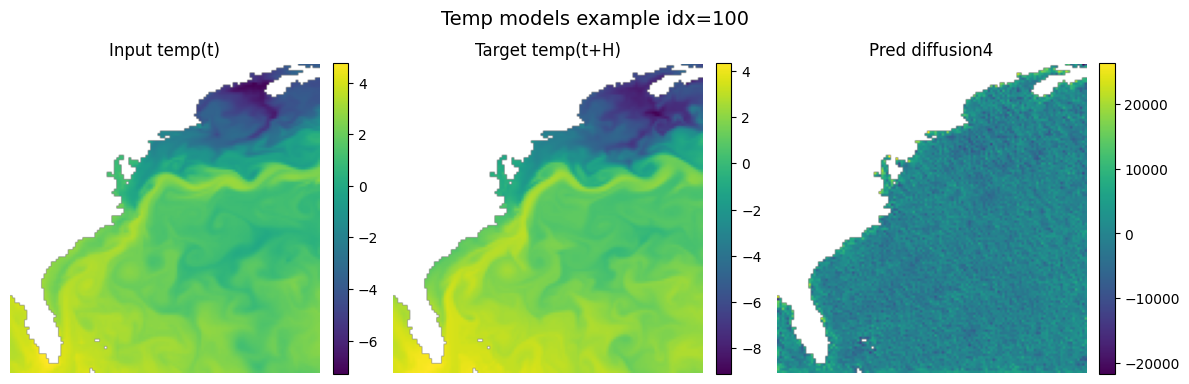

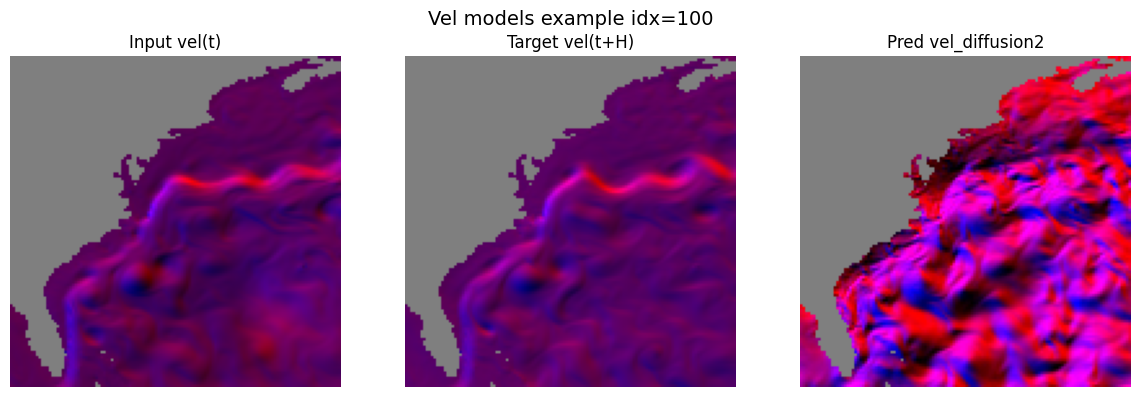

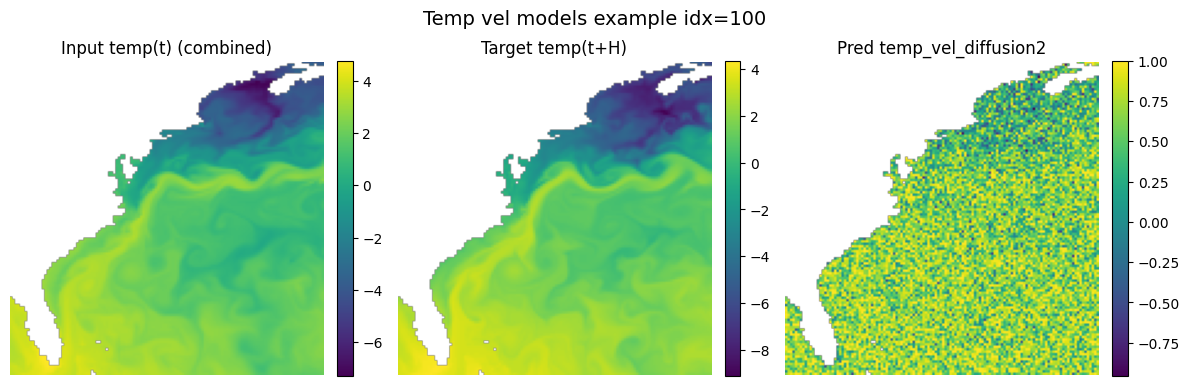

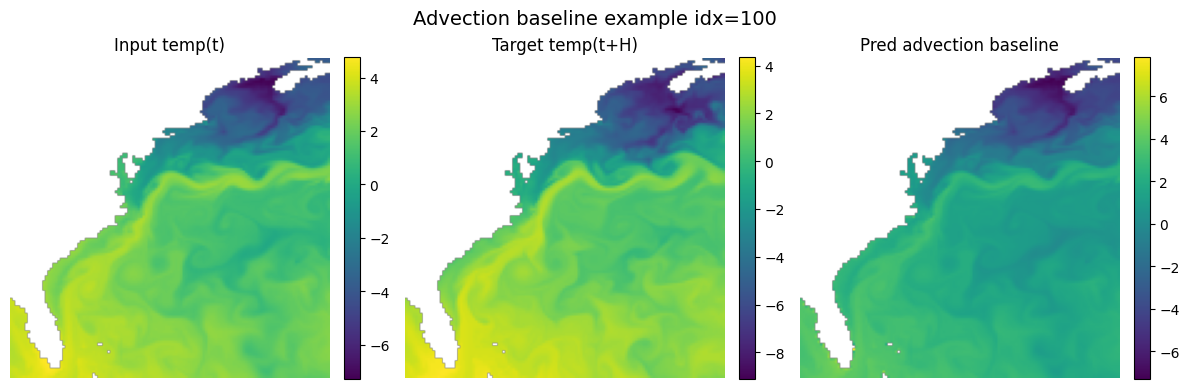

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Pick an example index
idx = 100  # change if you want a different sample

VALID_MASK_2D = VALID_MASK[0, 0].cpu().numpy().astype(bool)


def temp_to_2d(arr):
    """
    arr: (H, W) or (1, H, W) or (2, H, W)
    Returns a numpy 2D array with land masked as NaN.
    For multi-channel arr, pass arr[c] explicitly.
    """
    if arr.ndim == 3 and arr.shape[0] == 1:
        arr2 = arr[0]
    else:
        arr2 = arr
    arr2 = arr2.copy()
    arr2[~VALID_MASK_2D] = np.nan
    return arr2


def plot_temp(ax, field_2d, title):
    im = ax.imshow(field_2d, origin='lower', cmap='viridis')
    ax.set_title(title)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


def vel_to_rgb(vel):
    """
    vel: (2, H, W) numpy array (u, v)
    Returns an RGB image where:
      R ~ u, B ~ v, G = 0, land = gray.
    Normalizes u and v separately to [0,1].
    """
    u = vel[0]
    v = vel[1]

    u_min, u_max = u.min(), u.max()
    v_min, v_max = v.min(), v.max()
    u_norm = (u - u_min) / (u_max - u_min + 1e-8)
    v_norm = (v - v_min) / (v_max - v_min + 1e-8)

    H, W = u.shape
    rgb = np.zeros((H, W, 3), dtype=np.float32)
    rgb[..., 0] = u_norm   # red = u
    rgb[..., 2] = v_norm   # blue = v

    # land = gray
    rgb[~VALID_MASK_2D] = 0.5
    return rgb


def plot_vel(ax, vel, title):
    """
    vel: (2, H, W) numpy array
    """
    rgb = vel_to_rgb(vel)
    ax.imshow(rgb, origin='lower')
    ax.set_title(title)
    ax.axis('off')


with torch.no_grad():
    
    temp_in, temp_out = temp_test[idx]   # temp_in: (2,H,W), temp_out: (1,H,W)

    temp_in_batch = temp_in.unsqueeze(0).to(DEVICE)   # (1,2,H,W)
    temp_out_batch = temp_out.unsqueeze(0).to(DEVICE) # (1,1,H,W)
    
    temp_in_np = temp_in.numpy()      # (2,H,W)
    temp_out_np = temp_out.numpy()    # (1,H,W)
    
    # ----------------- run all models -----------------
    predictions = []  # list of (name, pred_np) where pred_np is (1,H,W)
    
    with torch.no_grad():
        for result in temp_results:
            model = result["model"].to(DEVICE)
            name = result["name"]
    
            model.eval()
            pred = model(temp_in_batch)              # (1,1,H,W)
            pred_np = pred.cpu().squeeze(0).numpy()  # (1,H,W)
    
            predictions.append((name, pred_np))
    
    # ----------------- plotting -----------------
    n_models = len(predictions)
    n_cols = 2 + n_models  # Input, Target, and one column per model
    
    fig, axes = plt.subplots(1, n_cols, figsize=(4 * n_cols, 4))
    fig.suptitle(f"Temp models example idx={idx}", fontsize=14)
    
    # Column 0: input temp(t) – use channel 1 (current snapshot)
    plot_temp(axes[0], temp_to_2d(temp_in_np[3]), "Input temp(t)")
    
    # Column 1: target temp(t+H)
    plot_temp(axes[1], temp_to_2d(temp_out_np[0]), "Target temp(t+H)")
    
    # Remaining columns: each model prediction
    for j, (name, pred_np) in enumerate(predictions, start=2):
        plot_temp(axes[j], temp_to_2d(pred_np[0]), f"Pred {name}")
    
    plt.tight_layout()
    plt.show()

    # ===================== VEL MODELS =====================
    # Reuse the same idx as for temperatures
    vel_in, vel_out = vel_test[idx]   # (2,H,W), (2,H,W)
    
    vel_in_batch = vel_in.unsqueeze(0).to(DEVICE)  # (1,2,H,W)
    vel_in_np = vel_in.numpy()                     # (2,H,W)
    vel_out_np = vel_out.numpy()                   # (2,H,W)
    
    predictions_vel = []  # list of (name, pred_np) where pred_np is (2,H,W)
    
    with torch.no_grad():
        for result in vel_results:   # <-- list of best vel models
            model = result["model"].to(DEVICE)
            name = result["name"]
    
            model.eval()
            pred = model(vel_in_batch)               # (1,2,H,W)
            pred_np = pred.cpu().squeeze(0).numpy()  # (2,H,W)
    
            predictions_vel.append((name, pred_np))
    
    n_models_vel = len(predictions_vel)
    n_cols_vel = 2 + n_models_vel  # Input, Target, models
    
    fig, axes = plt.subplots(1, n_cols_vel, figsize=(4 * n_cols_vel, 4))
    fig.suptitle(f"Vel models example idx={idx}", fontsize=14)
    
    # Col 0: input vel(t)
    plot_vel(axes[0], vel_in_np, "Input vel(t)")
    
    # Col 1: target vel(t+H)
    plot_vel(axes[1], vel_out_np, "Target vel(t+H)")
    
    # Remaining cols: each model prediction
    for j, (name, pred_np) in enumerate(predictions_vel, start=2):
        plot_vel(axes[j], pred_np, f"Pred {name}")
    
    plt.tight_layout()
    plt.show()

    # ===================== COMBINED TEMP MODELS =====================
    # combined_test[idx]: (6,H,W), (1,H,W)
    comb_in, comb_out = temp_vel_test[idx]
    
    comb_in_batch = comb_in.unsqueeze(0).to(DEVICE)   # (1,6,H,W)
    comb_in_np = comb_in.numpy()                      # (6,H,W)
    comb_out_np = comb_out.numpy()                    # (1,H,W)
    
    # temp(t) is channel 1 in your comment
    temp_t_from_comb = comb_in_np[3]  # (H,W)
    
    predictions_comb = []  # list of (name, pred_np) where pred_np is (1,H,W)
    
    with torch.no_grad():
        for result in temp_vel_results:   # <-- list of best combined temp models
            model = result["model"].to(DEVICE)
            name = result["name"]
    
            model.eval()
            pred = model(comb_in_batch)               # (1,1,H,W)
            pred_np = pred.cpu().squeeze(0).numpy()   # (1,H,W)
    
            predictions_comb.append((name, pred_np))
    
    n_models_comb = len(predictions_comb)
    n_cols_comb = 2 + n_models_comb  # Input, Target, models
    
    fig, axes = plt.subplots(1, n_cols_comb, figsize=(4 * n_cols_comb, 4))
    fig.suptitle(f"Temp vel models example idx={idx}", fontsize=14)
    
    # Col 0: input temp(t) from combined tensor
    plot_temp(axes[0], temp_to_2d(temp_t_from_comb), "Input temp(t) (combined)")
    
    # Col 1: target temp(t+H)
    plot_temp(axes[1], temp_to_2d(comb_out_np[0]), "Target temp(t+H)")
    
    # Remaining cols: each model prediction
    for j, (name, pred_np) in enumerate(predictions_comb, start=2):
        plot_temp(axes[j], temp_to_2d(pred_np[0]), f"Pred {name}")
    
    plt.tight_layout()
    plt.show()

    # ===================== ADVECTION BASELINE =====================
    # Use same sample idx and non-diff vel prediction vel_pred_test_non_diff[idx]
    t_in_temp, t_out_temp = temp_test[idx]   # (4,H,W), (1,H,W)
    v_in, _ = vel_test[idx]                  # (2,H,W), (2,H,W)

    temp_now = t_in_temp[3:4].to(DEVICE)     # use current snapshot temp(t), shape (1,H,W)
    v_in_dev = v_in.to(DEVICE)

    adv_pred = advection_step(temp_now, v_in_dev,.1)  # (1,H,W)
    adv_pred_np = adv_pred.cpu().numpy()                       # (1,H,W)
    t_out_temp_np = t_out_temp.numpy()                         # (1,H,W)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f"Advection baseline example idx={idx}", fontsize=14)

    plot_temp(axes[0], temp_to_2d(temp_in_np[3]), "Input temp(t)")
    plot_temp(axes[1], temp_to_2d(t_out_temp_np[0]), "Target temp(t+H)")
    plot_temp(axes[2], temp_to_2d(adv_pred_np[0]), "Pred advection baseline")

    plt.tight_layout()
    plt.show()


In [ ]:
'''
Plot diffusion steps
'''

SAMPLES_STEP = 10

with torch.no_grad():
    
    temp_in, temp_out = temp_test[idx]   # temp_in: (2,H,W), temp_out: (1,H,W)

    temp_in_batch = temp_in.unsqueeze(0).to(DEVICE)   # (1,2,H,W)
    temp_out_batch = temp_out.unsqueeze(0).to(DEVICE) # (1,1,H,W)
    
    temp_in_np = temp_in.numpy()      # (2,H,W)
    temp_out_np = temp_out.numpy()    # (1,H,W)
    
    # ----------------- run all models -----------------
    samples = []
    
    with torch.no_grad():
        result = temp_results[0]
        model = result["model"].to(DEVICE)
        name = result["name"]
        
        model.eval()
        pred = model.forward_ex(temp_in_batch, samples)
        #pred_np = pred.cpu().squeeze(0).numpy()  # (1,H,W)
    
    # ----------------- plotting -----------------
    n_cols = 2 + len(samples)//SAMPLES_STEP  # Input, Target, and one column per sample
    
    fig, axes = plt.subplots(1, n_cols, figsize=(4 * n_cols, 4))
    fig.suptitle(f"temp backward diffusion idx={idx}", fontsize=14)
    
    # Column 0: input temp(t) – use channel 1 (current snapshot)
    plot_temp(axes[0], temp_to_2d(temp_in_np[3]), "Input temp(t)")
    
    # Column 1: target temp(t+H)
    plot_temp(axes[1], temp_to_2d(temp_out_np[0]), "Target temp(t+H)")
    
    # Remaining columns: each model prediction
    j = 2
    for sample_i in range(0, len(samples), SAMPLES_STEP):
        sample = samples[sample_i]
        plot_temp(axes[j], temp_to_2d(sample.cpu().squeeze(0).numpy()[0]), f"{sample_i}")
        j += 1

    
    plt.tight_layout()
    plt.show()



In [ ]:
len(samples)

/tmp/ipykernel_9420/664857100.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


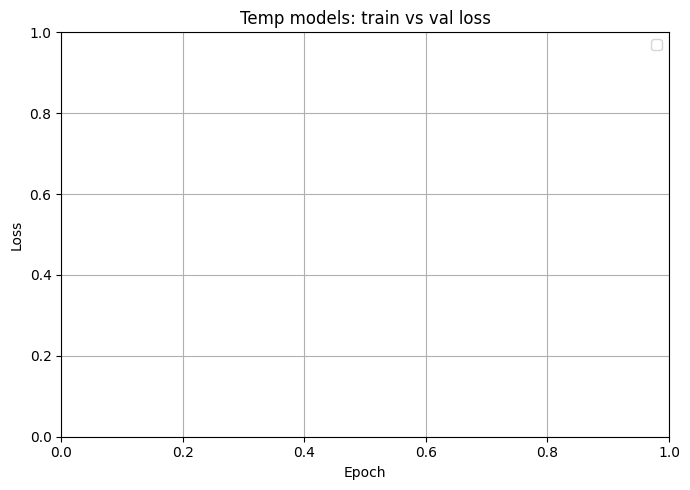

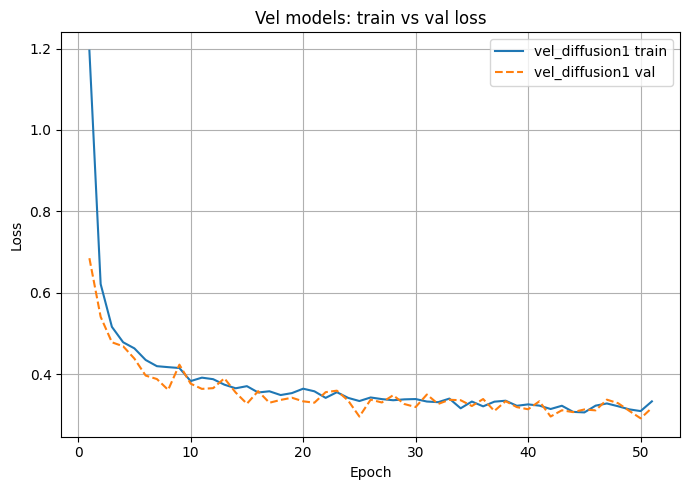

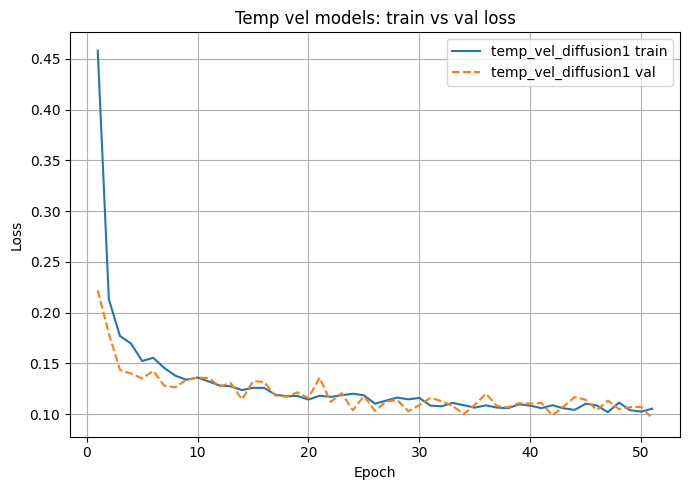

In [30]:
import matplotlib.pyplot as plt

def plot_losses(results, title):
    """
    results: list of dicts with keys 'train_losses', 'val_losses', optional 'name'
    """
    plt.figure(figsize=(7, 5))

    for i, res in enumerate(results):
        train_losses = res.get("train_losses", [])
        val_losses   = res.get("val_losses", [])
        name = res.get("name", f"model_{i}")

        if not train_losses and not val_losses:
            continue

        # x-axis = epoch numbers starting from 1
        e_train = range(1, len(train_losses) + 1)
        e_val   = range(1, len(val_losses) + 1)

        if train_losses:
            plt.plot(e_train, train_losses, label=f"{name} train")
        if val_losses:
            plt.plot(e_val, val_losses, linestyle="--", label=f"{name} val")

    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- call for each family of models ---

plot_losses(temp_results, "Temp models: train vs val loss")
plot_losses(vel_results, "Vel models: train vs val loss")
plot_losses(temp_vel_results, "Temp vel models: train vs val loss")
